# Identify delinquent people using Xgboost
Train an Xgboost model for binary classsifcation of the delinquent and solvent people.# 

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np
import os
import pandas as pd
import matplotlib.style as style
import matplotlib.pyplot as plt
import seaborn as sns
style.use('ggplot')
from IPython.display import display, HTML
from pylab import rcParams
%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

### No Scaling of features since I am using an Xgboost model

In [2]:
delinq_train = pd.read_csv("data/cs-training.csv", index_col=0)
print(delinq_train.shape)

(150000, 11)


In [3]:
train, valid = train_test_split(delinq_train, test_size=0.2, random_state=42,
                                          stratify=delinq_train.SeriousDlqin2yrs)
print(train.shape, valid.shape)

(120000, 11) (30000, 11)


In [4]:
seriousDlqin2yrs_train = train.SeriousDlqin2yrs
train = train[train.columns.difference(['SeriousDlqin2yrs'])]

X_train = np.array(train)
y_train = np.array(seriousDlqin2yrs_train.astype('category'))
print(X_train.shape, y_train.shape)

(120000, 10) (120000,)


In [5]:
seriousDlqin2yrs_valid = valid.SeriousDlqin2yrs
valid = valid[valid.columns.difference(['SeriousDlqin2yrs'])]

X_valid = np.array(valid)
y_valid = np.array(seriousDlqin2yrs_valid.astype('category'))
print(X_valid.shape, y_valid.shape)

(30000, 10) (30000,)


## XgBoost model training

In [6]:
scale_pos_weight = y_train.shape[0]/np.sum(y_train == 1)-1.0
scale_pos_weight

13.960728088766986

In [18]:
params = {
    'scale_pos_weight': [scale_pos_weight/3., scale_pos_weight/2., scale_pos_weight],
    'gamma': [20.0, 15.0],
    'early_stopping_rounds': [8],
    'max_depth': [7],
    'subsample': [.8],
    'colsample_bytree': [.8],
    'n_estimators': [150],
    'learning_rate': [0.05],
    'nthread': [5],
    'tree_method': ['hist']
}

xgb_classifier = xgb.XGBClassifier(eval_metric='aucpr')
rs = GridSearchCV(xgb_classifier, params, cv=3,
                  n_jobs=3, scoring='f1', verbose=1)

In [19]:
rs.fit(X_train, y_train)
gbm = rs.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:   48.9s finished


In [20]:
print(f"best score GBM: {rs.best_score_}\n"
                          f"best params GBM: {rs.best_params_}")

best score GBM: 0.4418178187177879
best params GBM: {'colsample_bytree': 0.8, 'early_stopping_rounds': 8, 'gamma': 15.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 150, 'nthread': 5, 'scale_pos_weight': 4.653576029588995, 'subsample': 0.8, 'tree_method': 'hist'}


### Model performance evaluation
* Test the model performance on the validation data set.
* Also plot the feature importances.

In [21]:
"""
Compute binary classification metrics
"""

def compute_validation_acc(model,features_test,target):
    predict_proba=model.predict_proba(features_test)
    predicted=model.predict(features_test)
    pred_prob=np.array(predict_proba[:,1])
    area_under_curve =  roc_auc_score(target,pred_prob)
    labels=['non delinquent','delinquent']
    print("accuracy score:",accuracy_score(target,model.predict(features_test)))
    print(target.shape,np.sum(predicted))
    cm=confusion_matrix(target,predicted)
    print(cm)
    
    sns.set(rc={'figure.figsize':(18,5)})
    fig, ax=plt.subplots(1,3)
    fig.suptitle("Metrics for binary classification", fontsize=16)
    
    #confusion matrix
    akws = {"ha": 'center',"va": 'center',"size": 17}
    sns.heatmap(cm, annot=True,ax=ax[0],annot_kws=akws); #annot=True to annotate cells
    ax[0].set_xlabel('Predicted labels')
    ax[0].set_ylabel('True labels'); 
    ax[0].set_title('Confusion Matrix') 
    ax[0].xaxis.set_ticklabels(labels)
    ax[0].yaxis.set_ticklabels(labels)
    
    #ROC
    fpr, tpr, _ = metrics.roc_curve(target,  pred_prob)
    ax[1].plot(fpr,tpr,label=f"auc = {area_under_curve:.3f}")
    ax[1].set_xlabel('True positive rate')
    ax[1].set_title('ROC curve')
    ax[1].set_ylabel('False positive rate')
    ax[1].legend(loc="lower right")
    
    #precision recall
    precision, recall, thresholds = precision_recall_curve(target, pred_prob)
    f1 = f1_score(target, predicted)
    auc_pr = auc(recall, precision)
    ap = average_precision_score(target, pred_prob)
    print('f1=%.3f auc_pr=%.3f avg_pr=%.3f auc=%.3f' % (f1, auc_pr, ap,area_under_curve))
    
    ax[2].plot(precision,recall,label=f"auc_pr = {auc_pr:.3f}")
    ax[2].set_title('PR Curve')
    ax[2].set_xlabel('Recall')
    ax[2].set_ylabel('Precision')
    ax[2].legend(loc="upper right")
    #plt.show()

accuracy score: 0.9114
(30000,) 2817
[[26260  1735]
 [  923  1082]]
f1=0.449 auc_pr=0.407 avg_pr=0.407 auc=0.869


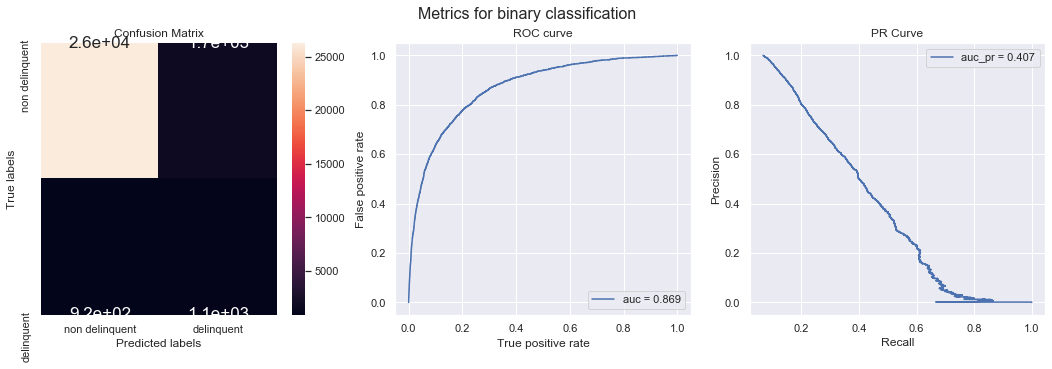

In [22]:
compute_validation_acc(gbm, X_valid,y_valid.astype(int))

Text(0, 0.5, 'Relative feature importance')

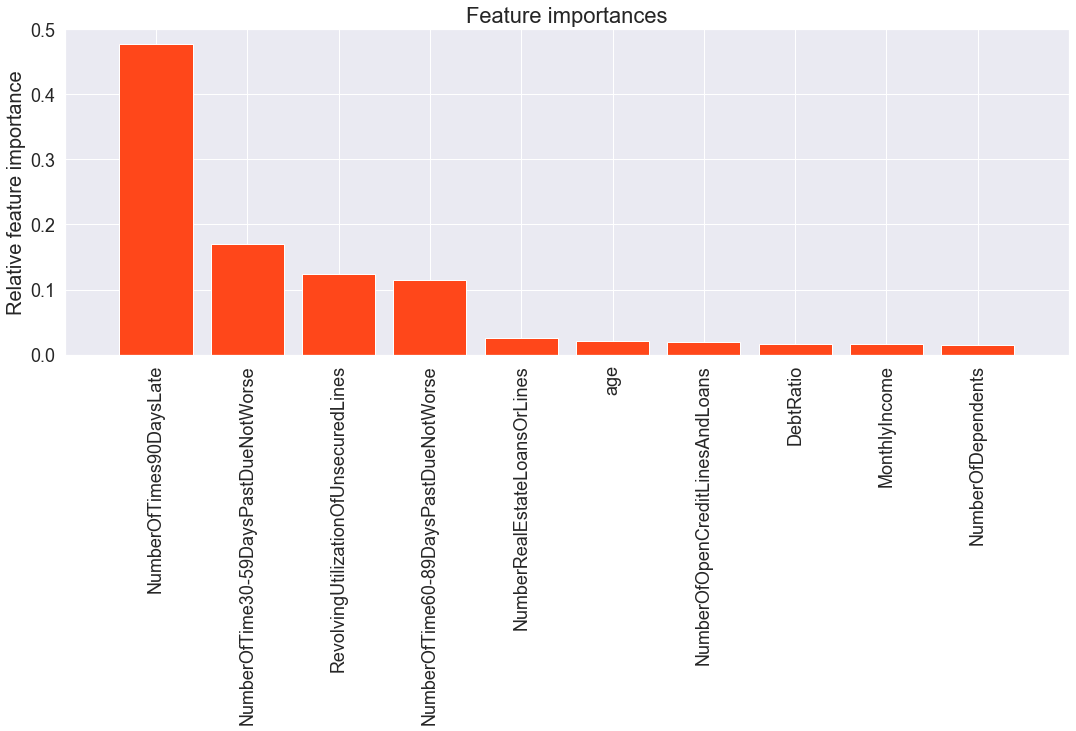

In [23]:
sorted_idx = np.argsort(gbm.feature_importances_)[::-1]
feature_importance = {}
for index in sorted_idx:
    feature_importance[train.columns[index]
                       ] = gbm.feature_importances_[index]

n_features = X_train.shape[1]
ss = sorted(feature_importance, key=feature_importance.get, reverse=True)
top_names = ss[0:]
f = plt.figure(figsize=(18, 6))
plt.grid(True)
plt.yticks(fontsize=18)
plt.xticks(range(n_features), top_names, rotation=90, fontsize=18)
plt.title("Feature importances", fontsize=22)
plt.bar(range(n_features), [feature_importance[i]
                            for i in top_names], color="#ff471a", align="center")
plt.xlim(-1, n_features)
plt.ylabel('Relative feature importance', fontsize=20)


## Submission

In [24]:
delinq_test = pd.read_csv("data/cs-test.csv")
delinq_test.rename(columns={"Unnamed: 0":"Id"}, inplace=True)
delinq_test.head()

,Id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [25]:
features_test = delinq_test[delinq_test.columns.difference(['Id', 'SeriousDlqin2yrs'])]
features_test = np.array(features_test)
delinq_test["Probability"] = gbm.predict_proba(features_test)[:,1]

In [26]:
delinq_test[["Id","Probability"]].to_csv("submission.csv", index=False)

### Submit via API

In [27]:
!kaggle competitions submit -c GiveMeSomeCredit -f submission.csv -m "first attempt"

100%|███████████████████████████████████████| 1.65M/1.65M [00:11<00:00, 146kB/s]
Successfully submitted to Give Me Some Credit